# PASA Proyecto 1

Eliminación de ruido de EOG y EMG

# Preparación del Entorno

- Instalación de librerías
- Descarga de Dataset

In [ ]:
# Para instalar en el entorno la librería para RW de archivos .edf
!pip install pyedflib
!pip install padasip

In [ ]:
# Usar este comando cambiando el final del link para descargar archivos individuales
# El database completo pesa 40.1 GB y va a estar todo el día
!wget -r -N -c -np https://physionet.org/files/capslpdb/1.0.0/n1.edf

# Carga de Datos

- Extracción de información del dataset
- Extracción de canales a analizar

*Probablemente haya que usar otra base de datos porque esta tiene pasabajos en 30Hz, y no se va a ver nada importante me parece*

In [1]:
from pyedflib import highlevel
signals, signal_headers, header = highlevel.read_edf('n1.edf')

## Información sobre el Dataset

In [2]:
print('Lista de Canales en esta base de datos: \n')
for sh in signal_headers:
  print(sh['label'], '  \t' ,sh['prefilter'],'  \tSample Rate:',sh['sample_rate'])

Lista de Canales en esta base de datos: 

ROC-LOC   	 LP:30.00Hz HP:0.30Hz NOTCH:50   	Sample Rate: 512.0
LOC-ROC   	 LP:30.00Hz HP:0.30Hz NOTCH:50   	Sample Rate: 512.0
F2-F4   	 LP:30.00Hz HP:0.30Hz NOTCH:50   	Sample Rate: 512.0
F4-C4   	 LP:30.00Hz HP:0.30Hz NOTCH:50   	Sample Rate: 512.0
C4-P4   	 LP:30.00Hz HP:0.30Hz NOTCH:50   	Sample Rate: 512.0
P4-O2   	 LP:30.00Hz HP:0.30Hz NOTCH:50   	Sample Rate: 512.0
F1-F3   	 LP:30.00Hz HP:0.30Hz NOTCH:50   	Sample Rate: 512.0
F3-C3   	 LP:30.00Hz HP:0.30Hz NOTCH:50   	Sample Rate: 512.0
C3-P3   	 LP:30.00Hz HP:0.30Hz NOTCH:50   	Sample Rate: 512.0
P3-O1   	 LP:30.00Hz HP:0.30Hz NOTCH:50   	Sample Rate: 512.0
C4-A1   	 LP:30.00Hz HP:0.30Hz NOTCH:50   	Sample Rate: 512.0
EMG1-EMG2   	 LP:100.00Hz HP:10.00Hz NOTCH:50   	Sample Rate: 256.0
ECG1-ECG2   	 LP:30.00Hz HP:0.30Hz NOTCH:50   	Sample Rate: 512.0
TERMISTORE   	 LP:3.00Hz HP:0.05Hz NOTCH:50   	Sample Rate: 64.0
TORACE   	 LP:3.00Hz HP:0.05Hz NOTCH:50   	Sample Rate: 64.0
ADDOME   	 L

La CAP Sleep Database es una colección de 108 grabaciones de Polysomniogramas del Sleep Disorders Center de Ospedale Maggiore de Parma, Italia.

Se usarán los siguientes canales para la eliminación de ruido de EEG por EOG o EMG:

- **ROC - LOC** corresponde al canal EOG de medición diferencial entre los transductores oculares derechos e izquierdos.
- **EMG1-EMG2** corresponde al canal EMG de medición diferencial entre los transductores en el músculo submental (debajo del mentón).
- **X# - Y#** corresponden a canales de EEG X# en referencia a Y#

Se debe notar que el ruido de línea ya está filtrado en esta base de datos

## Carga del Dataset

### Funciones Auxiliares

In [3]:
import padasip as pa
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [4]:
def signal_grab(signals, headers, i):
  '''
  Extract data to be used from the dataset
  '''
  retval = {
      'name': headers[i]['label'],
      'fs': headers[i]['sample_rate'],
      'data': signals[i]
  }
  return retval

def signal_grab_dt(signals, headers, i, dt):
  '''
  Extract data to be used from the dataset
  dt: Time period (s)
  '''
  fs = headers[i]['sample_rate']
  dt = np.array(dt)
  dt = dt * int(fs)
  retval = {
      'name': headers[i]['label'],
      'fs': fs,
      'data': signals[i][dt[0]:dt[1]]
  }
  return retval

In [5]:
def signal_plot(series, fig_size=(10,15)):
  figure, axes = plt.subplots(nrows= len(series), figsize=fig_size)
  for i,s in enumerate(series):
    axes[i].plot(s['data'])
    axes[i].set_title(s['name'])
    axes[i].set_xlabel('sample')
    axes[i].set_ylabel('units')
    axes[i].set_xlim((0,s['data'].size))
    
  plt.tight_layout()
  plt.show()

def signal_plot_N(series, N, fig_size=(10,15)):
  figure, axes = plt.subplots(nrows= len(series), figsize=fig_size)
  for i,s in enumerate(series):
    axes[i].plot(s['data'][:N])
    axes[i].set_title(s['name'])
    axes[i].set_xlabel('sample')
    axes[i].set_ylabel('units')
    axes[i].set_xlim((0,s['data'].size))
  
  plt.tight_layout()
  plt.show()

In [6]:
def spectrum_plot(series, fig_size=(10,15)):
  figure, axes = plt.subplots(nrows= len(series), figsize=fig_size)
  for i,s in enumerate(series):
    f, psd = signal.welch(s['data'], fs=s['fs'], window='bartlett')
    axes[i].loglog(f, psd)
    axes[i].set_title(s['name'])
    axes[i].set_xlabel('f [Hz]')
    axes[i].set_ylabel('PSD [V**2/Hz]')
    axes[i].set_xlim((1,1000))
    axes[i].set_ylim((1e-3,1e4))
  plt.show()

def spectrum_plot_n0(series, N0, fig_size=(10,15)):
  figure, axes = plt.subplots(nrows= len(series), figsize=fig_size)
  for i,s in enumerate(series):
    f, psd = signal.welch(s['data'], fs=s['fs'], window='bartlett', nfft = N0)
    axes[i].loglog(f, psd)
    axes[i].set_title(s['name'])
    axes[i].set_xlabel('f [Hz]')
    axes[i].set_ylabel('PSD [V**2/Hz]')
    axes[i].set_xlim((1,1000))
    axes[i].set_ylim((1e-3,1e4))
  plt.tight_layout()
  plt.show()

## Visualización de señales

In [ ]:
EEG = signal_grab(signals, signal_headers, 2)
EOG = signal_grab(signals, signal_headers, 0)
EMG = signal_grab(signals, signal_headers, 11)

In [7]:
dt = (0,20)
EEG = signal_grab_dt(signals, signal_headers, 2, dt)
EOG = signal_grab_dt(signals, signal_headers, 0, dt)
EMG = signal_grab_dt(signals, signal_headers, 11, dt)
ECG = signal_grab_dt(signals, signal_headers, 12, dt)
print(len(EMG['data']))
print(len(EOG['data']))
EMG['data']=signal.resample(EMG['data'],512*20)
print(len(EMG['data']))
print(len(EOG['data']))

5120
10240
10240
10240


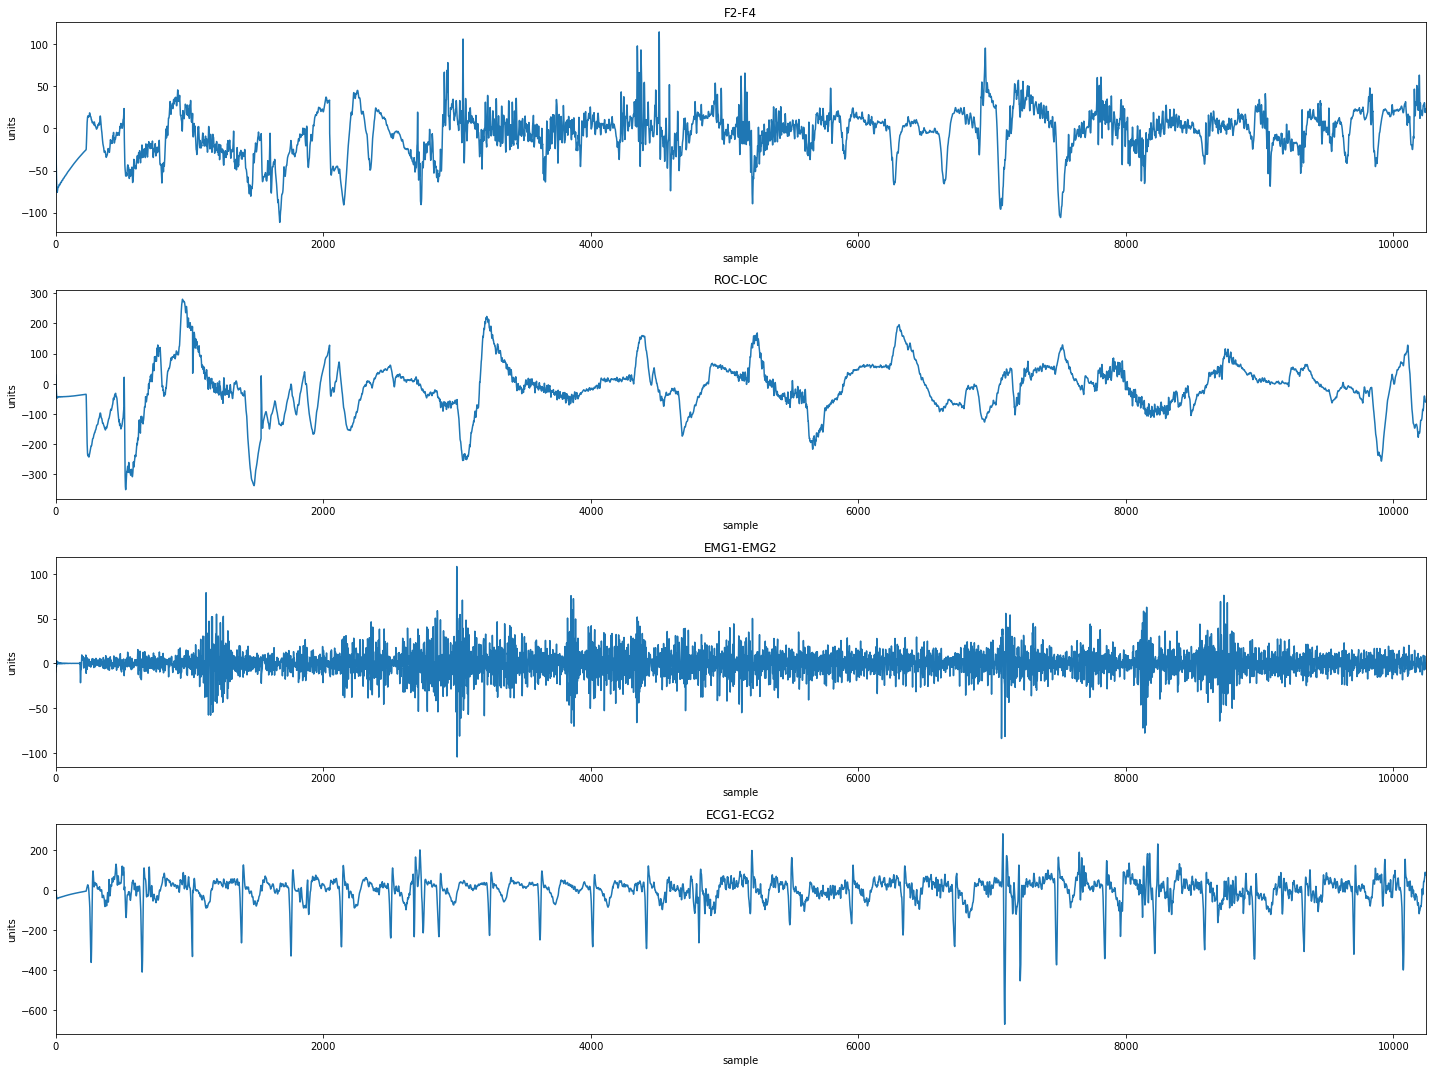

In [8]:
signal_plot([EEG, EOG, EMG, ECG], fig_size=(20,15))

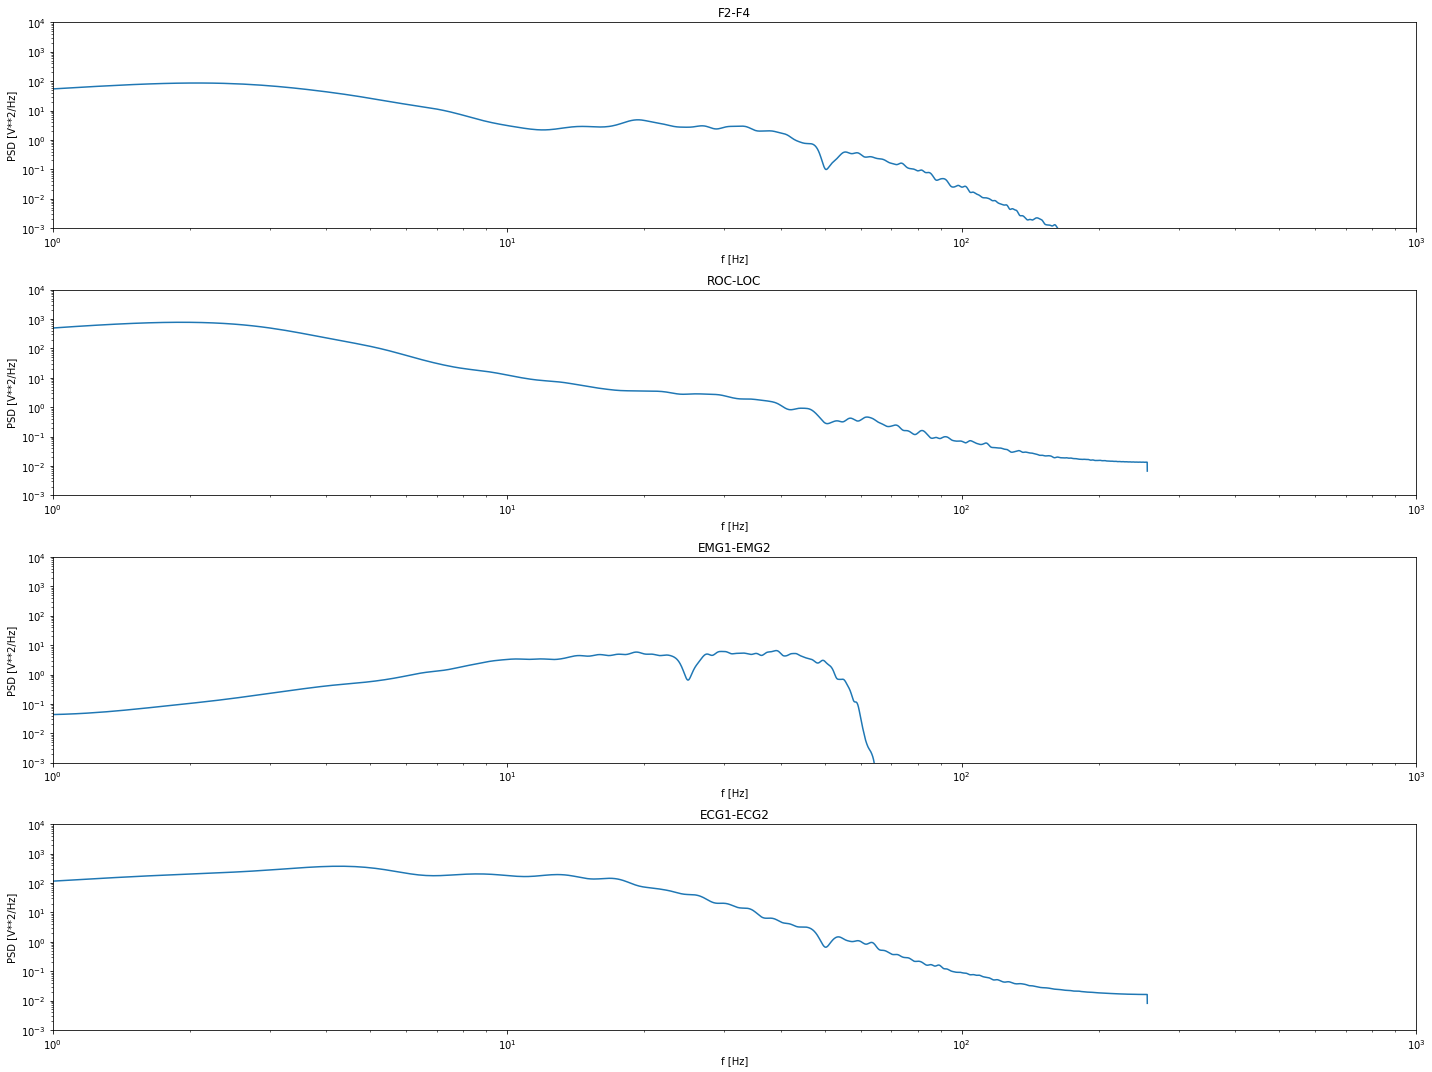

In [9]:
N0 = 4096
spectrum_plot_n0([EEG, EOG, EMG, ECG], N0, fig_size=(20,15))

# Procesamiento de Datos

In [13]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import progressbar as pb

## Funciones Auxiliares

In [10]:
def data_tap(x, M):
  '''
  Genera la matriz de taps MxN
  '''
  N = x.size
  x = np.array(x).reshape(N)
  x_M = np.zeros((N,M))
  
  # Zero-padding
  for m in range(M):
    x_M[m:,m] = x[:N-m]

  return x_M

## Análisis

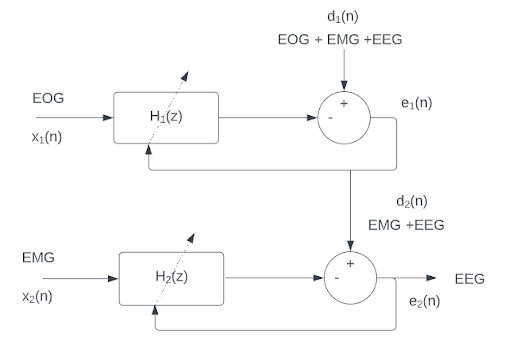

In [64]:
# Primer filtro: x1 = eog, d1 = eeg
M1 = 128
eog_M = data_tap(EOG['data'], M1)   # Reference Data (x)

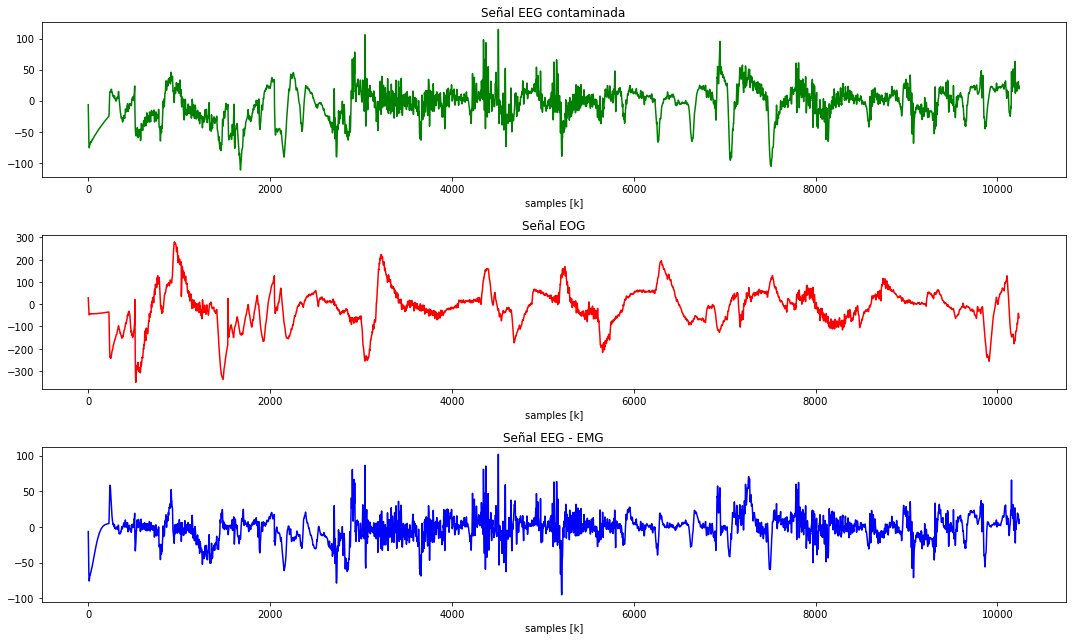

In [66]:
mu1 = 0.0000001
f1 = pa.filters.FilterLMS(n = M1, mu=mu1, w='zeros')
y1, e1, w1 = f1.run(EEG['data'],eog_M)

plt.figure(figsize=(15,9))
plt.subplot(311)
plt.title("Señal EEG contaminada");plt.xlabel("samples [k]")
plt.plot(EEG['data'],"g", label="eeg")

plt.subplot(312)
plt.title("Señal EOG");plt.xlabel("samples [k]")
plt.plot(EOG['data'],"r", label="eog")

plt.subplot(313)
plt.title("Señal EEG - EMG");plt.xlabel("samples [k]")
plt.plot(e1,"b", label="error")

plt.tight_layout()
plt.show()

El EMG tiene una frecuencia de muestreo la mitad que los EEG y EOG, por lo cual se le aplicará un interpolador lineal para tener la cantidad de muestras suficientes para procesarlo.

O, subsampleamos la salida del otro

In [58]:
# Segundo filtro: x2 = emg, d2 = e1 = eeg - eog
M2 = 2000
emg_M = data_tap(ECG['data'], M2)

In [62]:
mu2 = 0.00001
f2 = pa.filters.FilterLMS(n = M2, mu=mu2, w='zeros')
y2, e2, w2 = f2.run(e1,emg_M)

plt.figure(figsize=(15,9))
plt.subplot(311)
plt.title("Señal EEG - EOG");plt.xlabel("samples [k]")
plt.plot(e1[::2],"g", label="eeg")

plt.subplot(312)
plt.title("Señal EMG");plt.xlabel("samples [k]")
plt.plot(ECG['data'],"r", label="eog")

plt.subplot(313)
plt.title("Señal EEG filtrada");plt.xlabel("samples [k]")
plt.plot(e2,"b", label="error")

plt.tight_layout()
plt.show()

C:\Users\germa\anaconda3\lib\site-packages\padasip\filters\lms.py:164: RuntimeWarning: invalid value encountered in multiply
  return self.mu * x * e
C:\Users\germa\anaconda3\lib\site-packages\matplotlib\transforms.py:396: RuntimeWarning: overflow encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)


IndexError: index 0 is out of bounds for axis 0 with size 0

IndexError: index 0 is out of bounds for axis 0 with size 0

In [27]:
def plot_w(w, M):
  figure, axes = plt.subplots(nrows=M, figsize=(15,10))
  for i in range(M):
    axes[i].plot(w[:,i])
  plt.show()

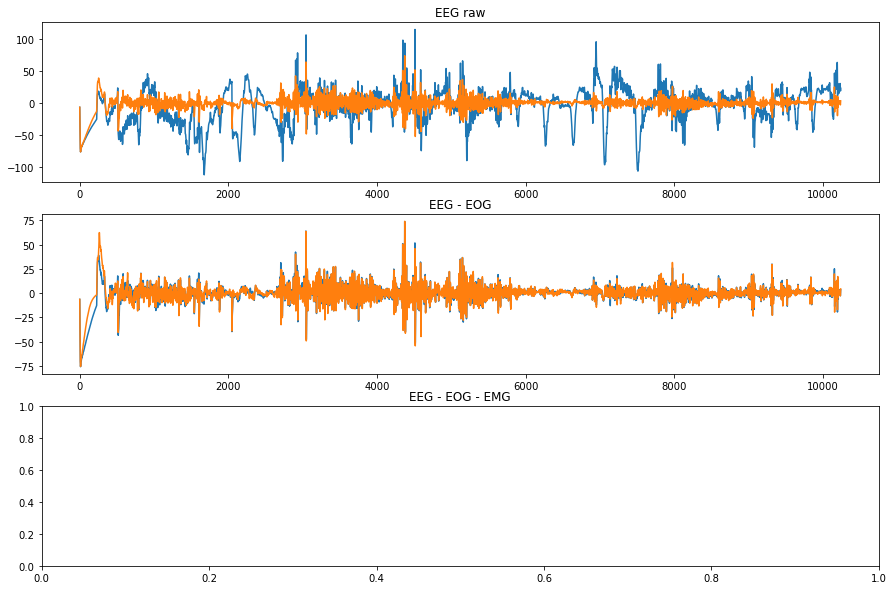

In [26]:
figure, axes = plt.subplots(nrows = 3, figsize=(15,10))
axes[0].plot(EEG['data']), axes[0].set_title('EEG raw')
axes[1].plot( e1), axes[1].set_title('EEG - EOG')
axes[0].plot( e1), axes[1].set_title('EEG - EOG')
axes[1].plot( e2), axes[2].set_title('EEG - EOG - EMG')
plt.show()

In [52]:
def spectrum_plot_n0(series, N0, fig_size=(10,15)):
  figure, axes = plt.subplots(nrows= len(series), figsize=fig_size)
  for i,s in enumerate(series):
    f, psd = signal.welch(s['data'], fs=s['fs'], window='bartlett', nfft = N0)
    axes[i].loglog(f, psd)
    axes[i].set_title(s['name'])
    axes[i].set_xlabel('f [Hz]')
    axes[i].set_ylabel('PSD [V**2/Hz]')
    axes[i].set_xlim((1,1000))
    axes[i].set_ylim((1e-3,1e4))
  plt.tight_layout()
  plt.show()
    

NameError: name 'e1dt' is not defined

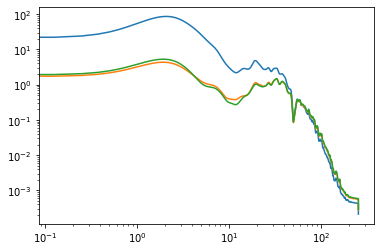

In [56]:
fs=512
feeg, psdeeeg = signal.welch(EEG['data'], fs, window='bartlett', nfft = N0)
fe1, psde1 = signal.welch(e1, fs, window='bartlett', nfft = N0)
fe2, psde2 = signal.welch(e2, fs, window='bartlett', nfft = N0)
plt.loglog(feeg, psdeeeg)
plt.loglog(fe1, psde1)
plt.loglog(fe2, psde2)
plt.show()

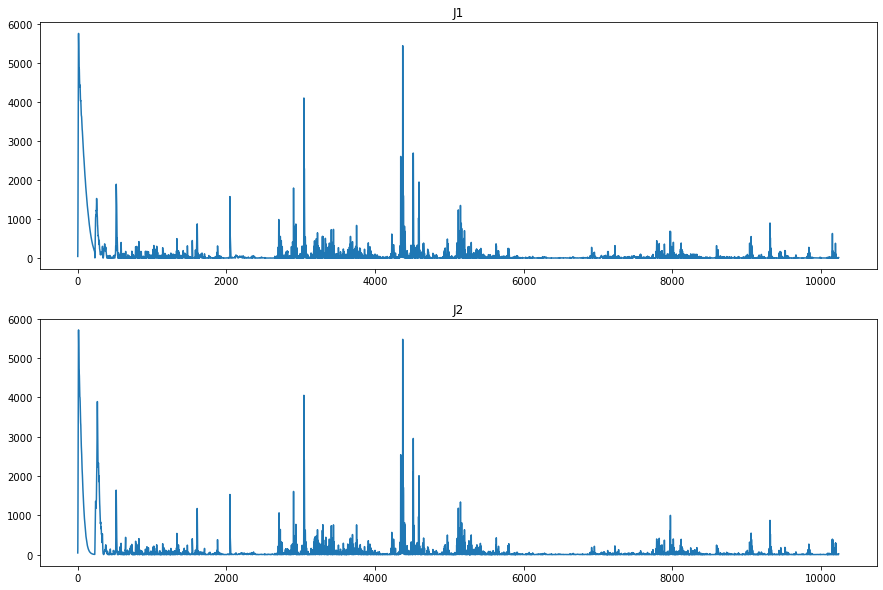

In [29]:
J1=e1*e1
J2=e2*e2
figure, axes = plt.subplots(nrows = 2, figsize=(15,10))
axes[0].plot(J1), axes[0].set_title('J1')
axes[1].plot(J2), axes[1].set_title('J2')
plt.show()

Montecarlo

In [48]:
x=EEG['data']
y=EOG['data']
R=np.cov(x,rowvar=True)
print(R)
#q,sigma,qh=np.linalg.svd(R)
#(w_montecarlo, J_montecarlo)=calc_lms_montecarlo(100,0,0.0001,512*20)
#plt.plot(J_montecarlo)

717.4232032162422


In [34]:
def calc_lms_montecarlo(K, w0, mu, N):
    """
    Realiza una simulación de Monte-Carlo del algoritmo LMS
    aplicado a un problema de predicción lineal de orden uno.
    
    K: número de simulaciones de Monte-Carlo
    w0: valor inicial del filtro adaptativo
    mu: parámetro de paso
    N: número de iteraciones
    """
    
    # Simulación de Monte Carlo
    w_montecarlo = np.zeros((N, 1))
    J_montecarlo = np.zeros((N, 1))
    
    for i in range(K):
        #x = get_model_output(N)
        
        # Predicción LMS
        w = np.zeros((N, 1))
        J = np.zeros((N, 1))
        w[0] = w0
        
        for n in range(1, N):
            y_hat = w[n - 1] * x[n - 1]             # Ecuación de filtrado
            #y = y[n]
            e = y[n] - y_hat
            J[n - 1] = e * e
            w[n] = w[n - 1] + mu * x[n - 1] * e     # Ecuación LMS

        J[N - 1] = J[N - 2]
        
        w_montecarlo += w
        J_montecarlo += J
        
    w_montecarlo /= K
    J_montecarlo /= K
    
    return (w_montecarlo, J_montecarlo)


# Análisis

In [ ]:
plt.scatter(EEG['data'][::2], EMG['data'], marker='.')